Functions for generating data to test random features classifier.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy import signal
import seaborn as sns

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = fs / 2
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return signal.lfilter(b, a, data)

def highpass_filter(data, highcut, fs, order=2):
    nyq = fs/2
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, lowcut, fs, order=2):
    nyq = fs/2
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return signal.filtfilt(b, a, data)

In [4]:
def noisy_sin_signal(f_s=2000, dur=10, f_signal=40, sig_dur=0.05, a=1, seed=2):
    '''
    Generate a time series of random noise interspersed with periods where a sinusoidal signal is on
    
    Parameters
    ----------
    
    f_s = sampling frequency (Hz)
    dur = duration of the time series (s)
    f_signal = frequency of the signal (Hz)
    sig_dur = duration of the signal (s)
    a: 2x amplitude of the signal used for snr (between 0 and 1)
    if n_amp = 2 x noise_amplitude: a ** 2 + n_amp ** 2 = 1; snr = a**2/n_amp**2
    
    Returns
    -------
    time_series: an array of shape (f_s * dur, 1)
    labels: array with binary values (0, 1) shape (f_s * dur, )
    '''
    np.random.seed(seed)
    
    if a < 0 or a > 1:
        raise ValueError('a should be between 0 and 1')
    n_amp = np.sqrt(1 - a ** 2) 
    
    t_points = np.arange(0, dur, 1/f_s)
    t_series = np.random.normal(0, (a + n_amp)/2, dur * f_s)
    label = np.zeros(len(t_series))
    
    d = int(sig_dur * f_s) # array len of signal
    p = np.arange(0, len(t_points), d) # array with points d apart
    idx = np.random.choice(p, int(dur / (2 * sig_dur)), replace=False)
    for i in idx:
        t = t_points[i:i + d]
        t_series[i:i + d] = a / 2 * np.sin(2 * np.pi * f_signal * t) + np.random.normal(0, n_amp / 2, len(t))
        label[i:i + d] = 1
    return t_series, label

In [63]:
def data_matrix(series, label, N=40):
    ''' 
    From a time series, generate a n_sample x n_feature matrix using overlapping windows.
    
    Parameters
    ----------
    series: 1-D numpy array shape (M, 1)
    label: 1-D numpy array shape (M, 1)
    N: n_features of the data matrix
    
    Returns
    -------
    X: array of shape (M - N, N)
    y: array of shape (M - N, )
    '''
    X = np.array([series[i:i + N] for i in range(len(series) - N)])
    y = label[N:]
    return X, y                       

The length of time the signal is on is 5.00 s
(19840, 160)


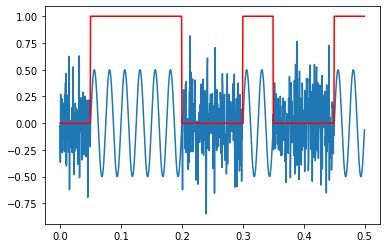

In [92]:
f_s = 2000
dur = 10
t = np.arange(0, dur, 1/f_s)
series, label = noisy_sin_signal(f_s=f_s, dur=dur, a=1, seed=22)

fig = plt.figure()
plt.plot(t[:1000], series[:1000])
plt.plot(t[:1000], label[:1000], 'r')
print('The length of time the signal is on is %0.2f s' % (len(label[label == 1]) / f_s))

mem = 0.08
N = int(mem * f_s)
X, y = data_matrix(series, label, N)
print(X.shape)

In [93]:
def relu(x, thrsh=0):
    return np.maximum(x, thrsh)

The length of time the signal is on is 5.00 s


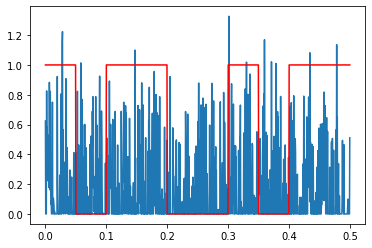

In [95]:
series, label = noisy_sin_signal(f_s=f_s, dur=dur, a=0.5, seed=33)
rel_series = relu(series)

fig = plt.figure()
plt.plot(t[:1000], rel_series[:1000])
plt.plot(t[:1000], label[:1000], 'r')
print('The length of time the signal is on is %0.2f s' % (len(label[label == 1]) / f_s))

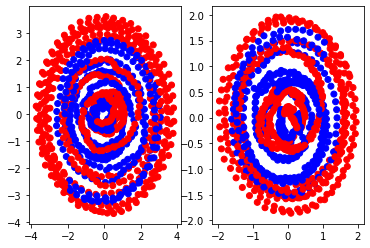

In [83]:
# visualize X before and after relu using dimensionality reduction
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

series, label = noisy_sin_signal(f_s=f_s, dur=dur, a=0.8, seed=22)
rel_series = relu(series)

X, y = data_matrix(series, label, N)
X_rel, y = data_matrix(rel_series, label, N)
col = np.array(['r' if n == 1 else 'b' for n in y])

coords = pca.fit_transform(X)
coords_rel = pca.fit_transform(X_rel)

fig = plt.figure()
ax = fig.add_subplot(121)
x, y = np.split(coords, 2, axis=1)
plt.scatter(x[:1000], y[:1000], c=col[:1000])

ax = fig.add_subplot(122)
x, y = np.split(coords_rel, 2, axis=1)
plt.scatter(x[:1000], y[:1000], c=col[:1000])